In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay



In [2]:
data=pd.read_csv("Fraud_check.csv")

In [3]:
data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [4]:
class Node():
    def __init__(self,feature=None,threshold=None,right=None,left=None,value=None,is_categorical=False):
        self.feature=feature  ## feature on which this node is  splitted 
        self.threshold=threshold ## Threshold at which its splitted 
        self.right=right ##Right Subtree
        self.left=left ## Left subtree
        self.value=value ##Class value, valid only for leaf node

    def _is_leaf(self):
        return self.value is not None

In [5]:
class DecisionTree():
    def __init__(self,min_samples_split=10,max_depth=100,n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self,X,y):
        self.n_features=X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)

        self.root=self._grow_tree(X,y)

    def _grow_tree(self,X,y,depth=0):

        n_samples,n_feats=X.shape
        n_lables=len(np.unique(y))

        ## check stoping criteria 
        if (depth>=self.max_depth or n_lables==1 or n_samples<self.min_samples_split):
            leaf_value=self._most_common_label(y)
            
            return Node(value=leaf_value)
        

        ## Find best split
        feat_idx=np.random.choice(n_feats,self.n_features,replace=False)


        best_feature,best_thresh=self._best_split(X,y,feat_idx)

        ##Create child Node

        left_idx,right_idx=self._split(X[:,best_feature],best_thresh)

        Left=self._grow_tree(X[left_idx, :],y[left_idx],depth+1)
        Right=self._grow_tree(X[right_idx, :],y[right_idx],depth+1)

        return Node(best_feature,best_thresh,Right,Left)


        ## create child nodes
    def _best_split(self,X,y,feat_idxs):
        best_gain=-1
        split_idx=None
        split_threshold=None

        ## select best feature and threshold combination on the basis of information gain

        for feat_idx in feat_idxs:
            X_column=X[:,feat_idx]
            thresholds=np.unique(X_column)

            for thr in thresholds:
                gain=self._information_gain(y,X_column,thr)
                
                if gain>best_gain:
                    best_gain=gain
                    split_idx=feat_idx
                    split_threshold=thr
        return split_idx,split_threshold

    def _information_gain(self,y,X_column,thereshold):

        ##entropy of parent

        parent_entropy=self._entropy(y)

        ## get child by spliting on the basis of a feature and the given thereshold

        left_idx,right_idx=self._split(X_column,thereshold)

        if len(left_idx)==0 or len(right_idx)==0:
            return 0
        n=len(y)
        n_l,n_r=len(left_idx),len(right_idx)

        ## Entropy of each child

        l_e,r_e=self._entropy(y[left_idx]),self._entropy(y[right_idx])

        ## weighted average of child entropy 

        child_entropy=((n_l*l_e)+(n_r*r_e))/n

        return parent_entropy-child_entropy


    def _split(self,X_column,split_thresh,is_categorical=False):
        
        left_idx=np.argwhere(X_column <= split_thresh).flatten()
        right_idx=np.argwhere(X_column > split_thresh).flatten()

        return left_idx,right_idx


    def _entropy(self,y):
        hist=np.bincount(y)
        px=hist/len(y)
        entropy=0

        for p in px:
            if p>0:
                entropy+=p*np.log2(p)
        return -1*entropy
        
            
    def _most_common_label(self,y):
        # print(y)
        counter=Counter(y)
        return counter.most_common(1)[0][0]
        
        

    def predict(self,X):
        prediction=[]
        for x in X:
            prediction.append(self._traverse_tree(x,self.root))
        return prediction

    def _traverse_tree(self,x,node):
        if node._is_leaf():
            return node.value
        if (x[node.feature]<=node.threshold) :
            return self._traverse_tree(x,node.left)
        else:
            return self._traverse_tree(x,node.right)

    
    def _print_tree(self):
        self._print_traverse(self.root,"")
        

    def _print_traverse(self,node,space_string):
        if node._is_leaf():
            print(space_string,end='')
            print("class=",node.value)
            return
        print(space_string,end='')
        print("feature_",node.feature, "<=",node.threshold)
  
        self._print_traverse(node.left,space_string+"---")
        
        print(space_string,end='')

        print("feature_",node.feature, ">",node.threshold)
        self._print_traverse(node.right,space_string+"---")
        
    

In [6]:
categorical_feature=["Marital.Status","Urban","Undergrad"]
one_hot_encoded_data = pd.get_dummies(data, columns = categorical_feature,dtype='int')
final_data=one_hot_encoded_data.drop("Taxable.Income",axis=1)


In [7]:
final_data

,City.Population,Work.Experience,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Undergrad_NO,Undergrad_YES
0,50047,10,0,0,1,0,1,1,0
1,134075,18,1,0,0,0,1,0,1
2,160205,30,0,1,0,0,1,1,0
3,193264,15,0,0,1,0,1,0,1
4,27533,28,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
595,39492,7,1,0,0,0,1,0,1
596,55369,2,1,0,0,0,1,0,1
597,154058,0,1,0,0,0,1,1,0
598,180083,17,0,1,0,1,0,0,1


In [8]:
labels=pd.DataFrame()
bins=[0,30001,100000]
labels["Taxable.Income"]=pd.cut(data['Taxable.Income'], bins=bins, labels=[0,1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(final_data, labels, test_size=0.20, random_state=42)

In [10]:
model=DecisionTree(min_samples_split=18,max_depth=80)

In [11]:
model.fit(np.array(X_train),np.array(y_train).flatten())

In [12]:
pred=model.predict(np.array(X_test))

In [19]:
accuracy=sum(((np.array(y_test)).flatten()==pred))/len(pred)
print("Test accuracy is :--",accuracy)

Test accuracy is :-- 0.7083333333333334


In [14]:
cnfmt=confusion_matrix((np.array(y_test)).flatten(), pred,labels=[0,1])

In [15]:
y_test.value_counts()

Taxable.Income
1                 94
0                 26
Name: count, dtype: int64

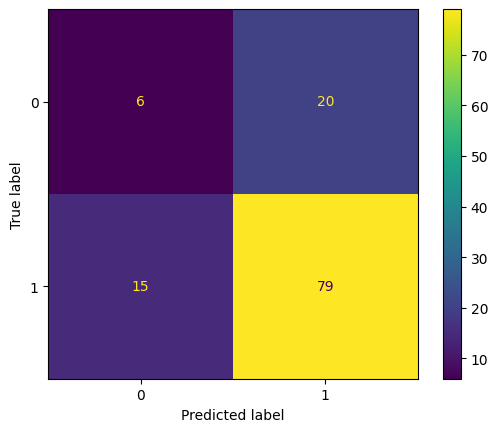

In [16]:
ConfusionMatrixDisplay(cnfmt).plot()

In [17]:
model._print_tree()

feature_ 3 <= 0
---feature_ 1 <= 29
------feature_ 1 <= 23
---------feature_ 1 <= 0
------------class= 1
---------feature_ 1 > 0
------------feature_ 0 <= 109191
---------------feature_ 0 <= 82565
------------------feature_ 0 <= 78897
---------------------feature_ 1 <= 12
------------------------feature_ 7 <= 0
---------------------------feature_ 1 <= 9
------------------------------class= 1
---------------------------feature_ 1 > 9
------------------------------class= 1
------------------------feature_ 7 > 0
---------------------------class= 1
---------------------feature_ 1 > 12
------------------------feature_ 1 <= 20
---------------------------feature_ 0 <= 26884
------------------------------class= 1
---------------------------feature_ 0 > 26884
------------------------------feature_ 0 <= 37776
---------------------------------class= 0
------------------------------feature_ 0 > 37776
---------------------------------feature_ 0 <= 44251
------------------------------------class= 1
